In [1]:
library(Seurat)
library(ggplot2)
UMAP_theme <- theme_bw()+theme(axis.text.y = element_blank(), 
                               axis.text.x = element_blank(), 
                               axis.ticks.x= element_blank(),
                               axis.ticks.y= element_blank(),
                               axis.title.x= element_blank(),
                               axis.title.y= element_blank(),
                               strip.text.x = element_text(size = 8),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.border = element_blank(),
                               panel.background = element_rect(colour = "black", fill = NA,size=.355),
                               legend.position = "none",
                               plot.title = element_text(hjust = 0.5, size = 8))

remove_grid = theme_bw() + theme( panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank())

Axis_themes <- theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 6),
                     axis.text.x = element_text(size = 6),
                     legend.text = element_text(size =6),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                    axis.line = element_line(size = .355), 
                    axis.ticks = element_line(size = .177))


Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp



In [2]:
library(stringr)
tcr = readRDS('L:/Duncan/Literature Data/Zheng/TCR/data/byCell/tcr.zhangLab.comb.flt.rds')
tcr$lin = sapply(tcr$meta.cluster.coarse, function(x) stringr::str_split(x, fixed('.'))[[1]][1])
tumor_clones = unique(tcr$cloneID[tcr$loc == 'T' ])#& tcr$meta.cluster %in% tumor_reactive])
tcr$tumor_clone = tcr$cloneID %in% tumor_clones
tcr$cellID.uniq = paste0(tcr$dataset.old,'.', tcr$Cell_Name)

In [3]:
library(dplyr)
sub = tcr %>% filter(loc == 'P', lin == 'CD8', cloneSize >0 )


Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
table(sub$dataset)


        BCL.thisStudy        CHOL.thisStudy      CRC.LeiZhang2018 
                  985                    77                   894 
HCC.ChunhongZheng2017          MM.thisStudy    NSCLC.XinyiGuo2018 
                  422                  1575                   963 

In [5]:
data_use = c('CRC.LeiZhang2018', 'HCC.ChunhongZheng2017', 'NSCLC.XinyiGuo2018', 'CHOL.thisStudy')

In [6]:
library(SingleCellExperiment)
datasets = unique(sub$dataset) %>% rev()
for (curr in data_use) {
    message(curr)
    if (curr == 'NSCLC.XinyiGuo2018') {
        curr = 'LC.XinyiGuo2018'
    }
    data = readRDS(paste0('L:/Duncan/Literature Data/Zheng/Expression/data/expression/CD8/byDataset/',curr,'.sce.RDS'))
    matrix = assay(data, 'counts') %>% as.matrix()
    rownames(matrix) = rowData(data)$geneSymbol
    if (curr %in% c('BCL.thisStudy', 'MM.thisStudy')) {
        rownames(matrix) = rowData(data)$display.name
    }
    colnames(matrix) = colData(data)$cellID.uniq
    seurat_obj = CreateSeuratObject(matrix)
    seurat_obj@meta.data = cbind(seurat_obj@meta.data, colData(data))
    seurat_obj = NormalizeData(seurat_obj)
    if (curr == data_use[1]) {
        seurat = seurat_obj
    }
    else {
        seurat = merge(seurat, seurat_obj)
    }
    
}
full = seurat

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
"package 'MatrixGenerics' was built under R version 4.1.1"
Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.1.3"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColS

In [7]:
full$class = sapply(full@meta.data$meta.cluster, function(x) str_split(x, fixed('.'))[[1]][3])
full$lin = sapply(full@meta.data$meta.cluster, function(x) str_split(x, fixed('.'))[[1]][1])


In [8]:
full_sub = subset(full, cells =colnames(full)[!full$patient %in% c('LUNG.P1208', 'LUNG.P1219')])
full_sub = subset(full_sub, cells = colnames(full_sub)[full_sub$lin == 'CD8'])
full_sub = subset(full_sub, cells = colnames(full_sub)[full_sub$loc != 'N'])

In [9]:
ifnb.list <- SplitObject(full_sub, split.by = "patient")

# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = ifnb.list)

In [10]:
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})

Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 148 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 160 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 141 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 160 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 148 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 182 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 146 anchors

Projecting new data onto SVD

Projecting new data o

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6945
Number of edges: 487941

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8909
Number of communities: 14
Elapsed time: 1 seconds


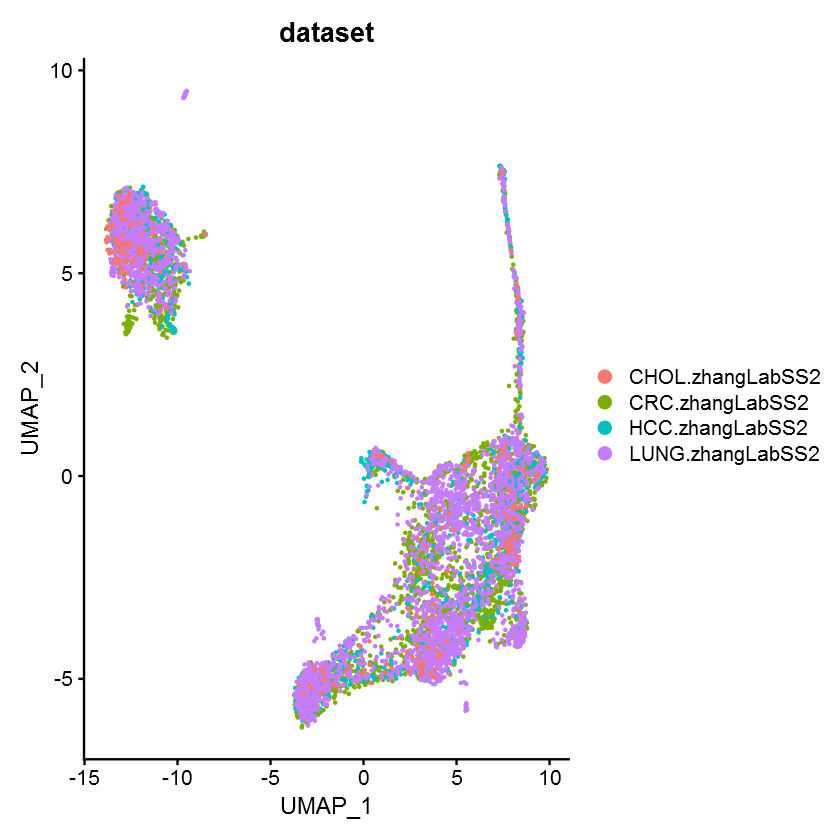

In [11]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features, reduction = "rpca")
immune.combined <- IntegrateData(anchorset = immune.anchors, features.to.integrate = rownames(GetAssayData(seurat)), k.weight = 50)
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.4)

DimPlot(immune.combined, group = 'dataset')

In [12]:
saveRDS(immune.combined, 'tumor_blood_integrated.RDS')